## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import plot_model

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

## Importing the dataset

In [2]:
# train_dir = '../dataset/fer2013/train/'
# test_dir = '../dataset/fer2013/test/'

train_dir = '../dataset/affectnet8/train/'
test_dir = '../dataset/affectnet8/val/'

# row, col = 48, 48
row, col = 224, 224
classes = 8

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

In [3]:
train_count

,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise
train,24882,3750,3803,6378,134415,74874,25459,14090


In [4]:
test_count

,Anger,Contempt,Disgust,Fear,Happiness,Neutral,Sadness,Surprise
test,500,499,500,500,500,500,500,500


## Plot number of images in dataset

In [5]:
df = pd.DataFrame()
df = pd.concat([df, train_count, test_count])
train_number, test_number = df.transpose().sum()[0], df.transpose().sum()[1]

fig = px.bar(
    df.transpose(),
    title='Training (' + str(train_number) + ') and Test (' + str(test_number) + ') count')
fig.show()

## Sample images

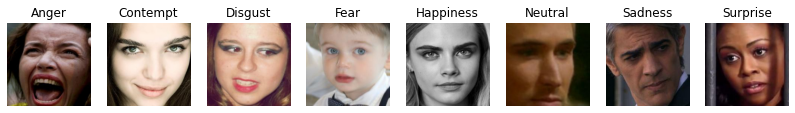

In [7]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,8,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Preprocessing the Data
This step is needed to avoid overfitting. To avoid overfitting, we apply transformations. These
transformations are simple geometrical transformations or zooms or some rotations on the images.
Transformations like transvections to shift some of the pixels, some zoom in and out, some rotations,
some horizontal flips, ... By doing this we will have augmented our images, we get new images, called
image augmentation. Image augmentation is thus transforming your training images so that the CNN model
doesn't overlearn or overtrain on the existing images. To augment variety and diversity of the images.

Data Generator :
https://keras.io/api/preprocessing/image/#imagedatagenerator-class

Different arguments which could be interesting to test out.

### Preprocessing the Training Data

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, # feature scaling (like normalization -> put every pixel between 0 and 1
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(row,col),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 287651 images belonging to 8 classes.


### Preprocessing the Test Set

We don't want to modify our images. We simply want to rescale them.

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(row,col),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 3999 images belonging to 8 classes.


In [10]:
emotions_dict = training_set.class_indices
emotions = list(emotions_dict.keys())
emotion_indices = list(emotions_dict.values())
emotions_dict

{'Anger': 0,
 'Contempt': 1,
 'Disgust': 2,
 'Fear': 3,
 'Happiness': 4,
 'Neutral': 5,
 'Sadness': 6,
 'Surprise': 7}

## Defining Model

In [11]:
# input_size last argument is 1 if gray scale and 3 if color scale
def get_model(input_size=(48, 48, 1), n_classes=7):
    # init CNN
    model = Sequential()

    # first convolution layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_size))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))

    # Second Convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu'))

    # Pooling
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Dropout(0.25))

    # Flattening
    model.add(Flatten())

    # Full Connection
    # one dimensional vector
    model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))

    # Output Layer
    # the activation function softmax makes sure to rescale the final values between zero and one and
    # that the sum of the values of all out layer neurons is equal to just 1
    model.add(Dense(units=n_classes, activation='softmax'))

    return model

# Training the CNN

## Compiling the CNN

In [12]:
model_ccn = get_model((row,col,1), classes)

In [13]:
opt = Adam(lr=0.0001, decay=10e-6)
# loss function : cross entropy -> corresponds to the cost function as MSE in other ML models
# we want to minimise the loss function in order to maximise the performance of the network
model_ccn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Model Summary

In [14]:
model_ccn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       1

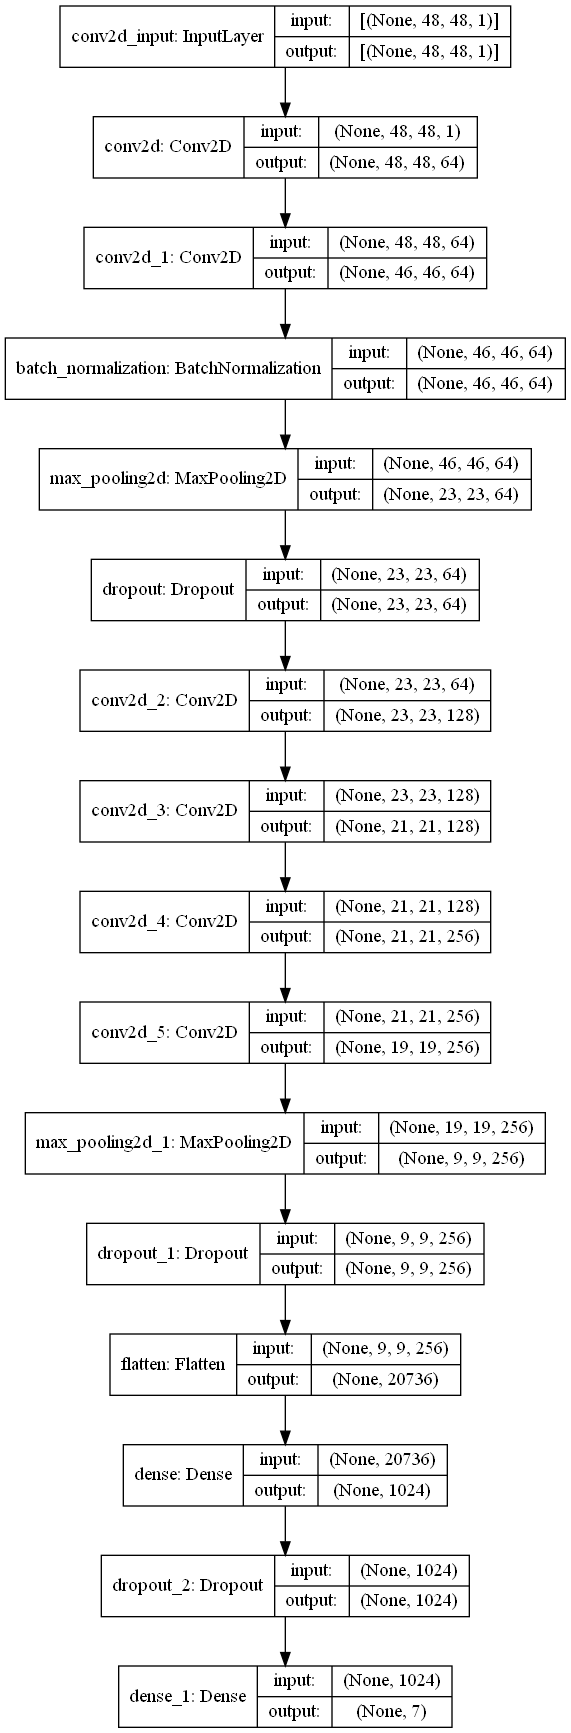

In [15]:
plot_model(model_ccn, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)


## Training Model on the training set

In [16]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = model_ccn.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[64,7] labels_size=[64,8]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-16-3948e9dabf83>:4) ]] [Op:__inference_train_function_1358]

Function call stack:
train_function


# Results

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = model_ccn.evaluate(training_set)
test_loss, test_accu = model_ccn.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

## Making a single Prediction

In [ ]:
test_image_angry = load_img('dataset/dataset/fer2013/test/PrivateTest_134207.jpg', target_size=(row, col))
# change image to be compatible with the prediction method
test_image_angry = img_to_array(test_image_angry) # convert to numpy array
# needed as we trained our data in batches
test_image_angry = np.expand_dims(test_image_angry, axis=0)  # axis=0 such that the dimension of the batch is first dimension

result = model_ccn.predict(test_image_angry)

# this can be fault as the prediction will most likely not be round
result_emotion = emotions[emotion_indices.index(result[0][0])]

print("the person emotion is :" + result_emotion)